In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import ipywidgets as widgets
from IPython.display import display, clear_output


In [62]:
df = pd.read_csv('/kaggle/input/set-data/body_measurements_dataset.csv')

# Convert height from feet/inches to inches
def height_to_inches(height):
    try:
        feet, inches = height.split("'")
        inches = inches.replace('"', '')
        return int(feet) * 12 + int(inches)
    except ValueError:
        raise ValueError(f"Invalid height format: {height}")

df['Height'] = df['Height'].apply(height_to_inches)

# Handle missing values (e.g., Cup Size)
df['Cup Size'] = df['Cup Size'].fillna('Unknown')
df = df.fillna(0)

# Convert categorical columns to numeric
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Cup Size'] = df['Cup Size'].astype('category').cat.codes

# Standardize the data
features = ['Height', 'Weight', 'Bust/Chest', 'Cup Size', 'Waist', 'Hips', 'Body Shape Index']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])


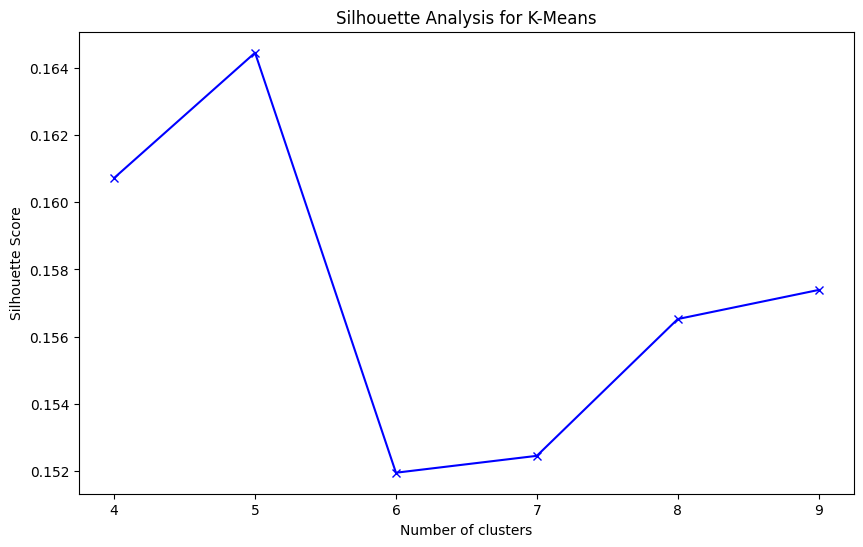

In [63]:
import warnings
warnings.filterwarnings('ignore')

# Determine optimal number of clusters using silhouette score for K-Means
range_n_clusters = list(range(4, 10))
silhouette_avg_kmeans = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg_kmeans.append(silhouette_score(df_scaled, cluster_labels))
    
# Plot silhouette scores for K-Means
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_kmeans, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Means')
plt.show()


In [64]:
# Determine optimal number of clusters using silhouette score for GMM
silhouette_avg_gmm = []

for num_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    gmm.fit(df_scaled)
    cluster_labels = gmm.predict(df_scaled)
    silhouette_avg_gmm.append(silhouette_score(df_scaled, cluster_labels))



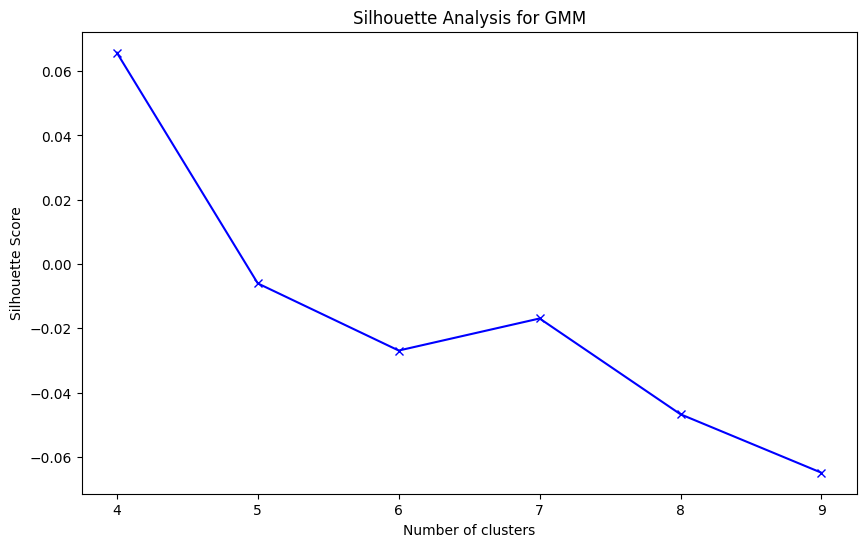

In [65]:
# Plot silhouette scores for GMM
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_gmm, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for GMM')
plt.show()


In [66]:
import warnings
warnings.filterwarnings('ignore')

# Fit K-Means with optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_avg_kmeans)]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster_KMeans'] = kmeans.fit_predict(df_scaled)

# Fit GMM with optimal number of clusters
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
df['Cluster_GMM'] = gmm.fit_predict(df_scaled)


In [67]:
import warnings
warnings.filterwarnings('ignore')

# Cross-validation with K-Means
cv_scores_kmeans = cross_val_score(kmeans, df_scaled, df['Cluster_KMeans'], cv=5)
mean_cv_score_kmeans = np.mean(cv_scores_kmeans)
# Print cross-validation scores
print(f"K-Means CV Scores: {cv_scores_kmeans}")
print(f"K-Means Mean CV Score: {mean_cv_score_kmeans}")


K-Means CV Scores: [-783.31962546 -813.52917608 -842.9054618  -823.02210172 -820.61276025]
K-Means Mean CV Score: -816.6778250630533


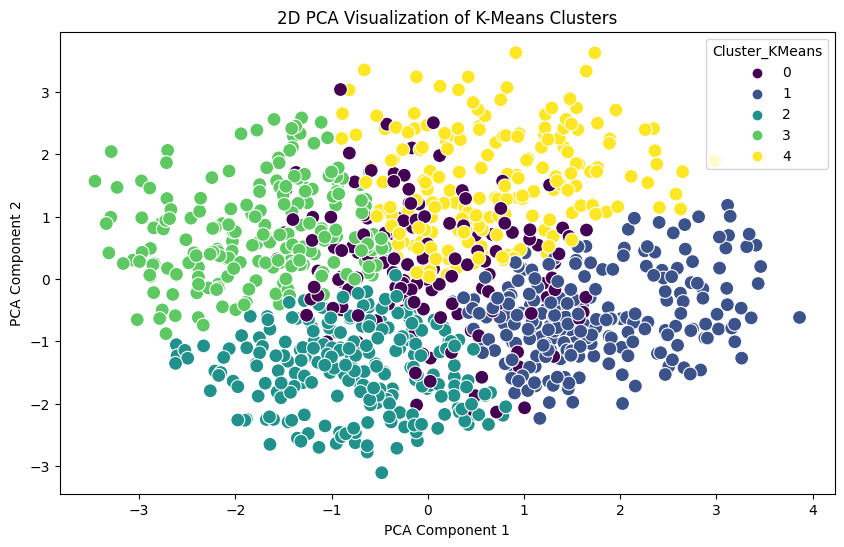

In [68]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', data=df, palette='viridis', s=100)
plt.title('2D PCA Visualization of K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [69]:
# 3D Scatter plot for body measurements (Height, Weight, Bust/Chest)
fig = px.scatter_3d(df, x='Height', y='Weight', z='Bust/Chest', color='Gender', symbol='Gender', opacity=0.8)
fig.update_layout(title='3D Scatter Plot of Body Measurements')
fig.show()


In [70]:
import warnings
warnings.filterwarnings('ignore')

# Neural Network Model
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['Gender'], test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [71]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5004 - loss: 0.6809 - val_accuracy: 0.7750 - val_loss: 0.5891
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8106 - loss: 0.5239 - val_accuracy: 0.8250 - val_loss: 0.4794
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.4448 - val_accuracy: 0.8875 - val_loss: 0.3437
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9365 - loss: 0.2853 - val_accuracy: 0.9250 - val_loss: 0.2310
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9495 - loss: 0.1795 - val_accuracy: 0.9375 - val_loss: 0.1614
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9706 - loss: 0.1245 - val_accuracy: 0.9375 - val_loss: 0.1362
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.0802 - val_accuracy: 0.9375 - val_loss: 0.1126
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9831 - loss: 0.0735 - val_accuracy: 0.9375 - val_loss

In [72]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0512 
Test Accuracy: 0.9850000143051147


In [73]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim  # Add this line

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
   
    def train_step(self, real_data):
        # Unpack the data
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Generate fake data
        batch_size = tf.shape(real_data)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_data = self.generator(random_latent_vectors)

        # Print shapes for debugging
        print("Generated data shape:", generated_data.shape)
        print("Real data shape:", real_data.shape)

        # Combine real and fake data
        combined_data = tf.concat([generated_data, real_data], axis=0)
        # Assign labels to real and fake data
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate misleading labels for the generator
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}



In [74]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(df_scaled.shape[1], activation='sigmoid')  # Ensure this matches the feature_dim of real_data
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(df_scaled.shape[1],)),  # Match feature_dim
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [75]:
# Initialize the GAN
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = GAN(generator, discriminator, latent_dim)

# Compile the GAN
gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

# Train the GAN
gan.fit(df_scaled, epochs=500, batch_size=64)


Epoch 1/500
Generated data shape: (None, 7)
Real data shape: (None, 7)
Generated data shape: (None, 7)
Real data shape: (None, 7)
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - d_loss: 0.7391 - g_loss: 0.4909
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.7171 - g_loss: 0.5118 
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.6888 - g_loss: 0.5435 
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.6515 - g_loss: 0.5939 
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6102 - g_loss: 0.6485 
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - d_loss: 0.5736 - g_loss: 0.6985
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.5436 - g_loss: 0.7482 
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.5073 - g_loss: 0.8022 
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.4690 - g_loss: 0.8712 
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - d_loss: 0.4276 - g_loss: 0.9457 
Epoch 11/500
16/16 ━━━━

In [76]:
print("Number of columns in df:", df.shape[1])

Number of columns in df: 12


In [77]:
def build_generator(latent_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')  # Ensure output_dim matches df columns
    ])
    return model

# Example usage:
output_dim = df.shape[1]  # Number of columns in df
generator = build_generator(latent_dim=100, output_dim=output_dim)

In [78]:
# Generate synthetic data
random_latent_vectors = tf.random.normal(shape=(100, latent_dim))
generated_data = generator(random_latent_vectors)

# Check the shape of generated data
print("Generated data shape:", generated_data.numpy().shape)

Generated data shape: (100, 12)


In [79]:
# Convert the generated data to a DataFrame
generated_df = pd.DataFrame(generated_data.numpy(), columns=df.columns)

# Combine real and synthetic data
augmented_df = pd.concat([df, generated_df], ignore_index=True)

In [80]:
def generate_size_chart(df, apparel_type):
    # Common quantiles for height and weight
    height_quantiles = [
        df['Height'].quantile(0.25),
        df['Height'].quantile(0.5),
        df['Height'].quantile(0.75),
        df['Height'].max()
    ]
    weight_quantiles = [
        df['Weight'].quantile(0.25),
        df['Weight'].quantile(0.5),
        df['Weight'].quantile(0.75),
        df['Weight'].max()
    ]

    if apparel_type == 'tops':
        size_chart = pd.DataFrame({
            'Size': ['S', 'M', 'L', 'XL'],
            'Bust/Chest': [df['Bust/Chest'].quantile(0.25),
                           df['Bust/Chest'].quantile(0.5),
                           df['Bust/Chest'].quantile(0.75),
                           df['Bust/Chest'].max()],
            'Waist': [df['Waist'].quantile(0.25),
                      df['Waist'].quantile(0.5),
                      df['Waist'].quantile(0.75),
                      df['Waist'].max()],
            'Height': height_quantiles,
            'Weight': weight_quantiles
        })
    elif apparel_type == 'bottoms':
        size_chart = pd.DataFrame({
            'Size': ['S', 'M', 'L', 'XL'],
            'Waist': [df['Waist'].quantile(0.25),
                      df['Waist'].quantile(0.5),
                      df['Waist'].quantile(0.75),
                      df['Waist'].max()],
            'Hips': [df['Hips'].quantile(0.25),
                     df['Hips'].quantile(0.5),
                     df['Hips'].quantile(0.75),
                     df['Hips'].max()],
            'Height': height_quantiles,
            'Weight': weight_quantiles
        })
    elif apparel_type == 'dresses':
        size_chart = pd.DataFrame({
            'Size': ['S', 'M', 'L', 'XL'],
            'Bust/Chest': [df['Bust/Chest'].quantile(0.25),
                           df['Bust/Chest'].quantile(0.5),
                           df['Bust/Chest'].quantile(0.75),
                           df['Bust/Chest'].max()],
            'Waist': [df['Waist'].quantile(0.25),
                      df['Waist'].quantile(0.5),
                      df['Waist'].quantile(0.75),
                      df['Waist'].max()],
            'Hips': [df['Hips'].quantile(0.25),
                     df['Hips'].quantile(0.5),
                     df['Hips'].quantile(0.75),
                     df['Hips'].max()],
            'Height': height_quantiles,
            'Weight': weight_quantiles
        })
    
    return size_chart

# Generate size charts
size_chart_tops = generate_size_chart(df, 'tops')
size_chart_bottoms = generate_size_chart(df, 'bottoms')
size_chart_dresses = generate_size_chart(df, 'dresses')

# Display the size charts
print("Size Chart for Tops:")
display(size_chart_tops)

print("Size Chart for Bottoms:")
display(size_chart_bottoms)

print("Size Chart for Dresses:")
display(size_chart_dresses)


Size Chart for Tops:


,Size,Bust/Chest,Waist,Height,Weight
0,S,33.0,29.0,63.0,60.0
1,M,38.0,34.0,68.0,71.0
2,L,43.0,39.0,73.0,83.0
3,XL,52.0,48.0,78.0,118.0


Size Chart for Bottoms:


,Size,Waist,Hips,Height,Weight
0,S,29.0,34.0,63.0,60.0
1,M,34.0,39.0,68.0,71.0
2,L,39.0,45.0,73.0,83.0
3,XL,48.0,50.0,78.0,118.0


Size Chart for Dresses:


,Size,Bust/Chest,Waist,Hips,Height,Weight
0,S,33.0,29.0,34.0,63.0,60.0
1,M,38.0,34.0,39.0,68.0,71.0
2,L,43.0,39.0,45.0,73.0,83.0
3,XL,52.0,48.0,50.0,78.0,118.0


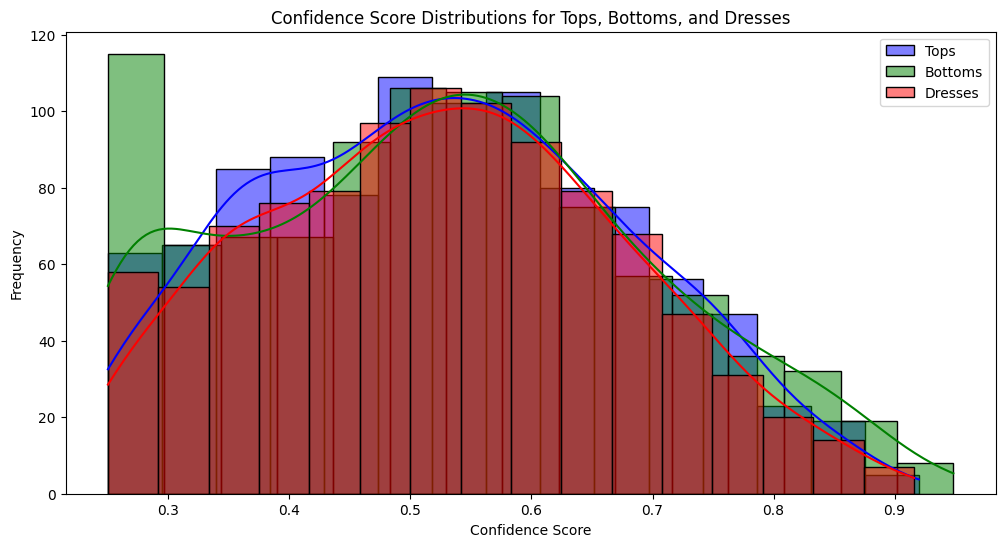

In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated function to calculate confidence scores for each size
def calculate_confidence(df, size_chart, apparel_type):
    confidence_scores = []
    for _, row in df.iterrows():
        if apparel_type == 'tops':
            score = np.mean([
                np.interp(row['Bust/Chest'], size_chart['Bust/Chest'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Waist'], size_chart['Waist'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Height'], size_chart['Height'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Weight'], size_chart['Weight'], [0.25, 0.5, 0.75, 1.0])
            ])
        elif apparel_type == 'bottoms':
            score = np.mean([
                np.interp(row['Waist'], size_chart['Waist'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Hips'], size_chart['Hips'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Height'], size_chart['Height'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Weight'], size_chart['Weight'], [0.25, 0.5, 0.75, 1.0])
            ])
        elif apparel_type == 'dresses':
            score = np.mean([
                np.interp(row['Bust/Chest'], size_chart['Bust/Chest'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Waist'], size_chart['Waist'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Hips'], size_chart['Hips'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Height'], size_chart['Height'], [0.25, 0.5, 0.75, 1.0]),
                np.interp(row['Weight'], size_chart['Weight'], [0.25, 0.5, 0.75, 1.0])
            ])
        confidence_scores.append(score)
    return confidence_scores

# Assuming df is your DataFrame
df['Confidence_Tops'] = calculate_confidence(df, size_chart_tops, 'tops')
df['Confidence_Bottoms'] = calculate_confidence(df, size_chart_bottoms, 'bottoms')
df['Confidence_Dresses'] = calculate_confidence(df, size_chart_dresses, 'dresses')

# Plot confidence score distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['Confidence_Tops'], color='blue', label='Tops', kde=True)
sns.histplot(df['Confidence_Bottoms'], color='green', label='Bottoms', kde=True)
sns.histplot(df['Confidence_Dresses'], color='red', label='Dresses', kde=True)
plt.title('Confidence Score Distributions for Tops, Bottoms, and Dresses')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [82]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Assuming the generate_size_chart function and size charts are already generated
# and available as size_chart_tops, size_chart_bottoms, size_chart_dresses

def predict_size(size_chart, height, weight, bust_chest=None, waist=None, hips=None):
    relevant_measurements = ['Height', 'Weight']
    normalized_input = np.array([height, weight])
    
    if 'Bust/Chest' in size_chart.columns:
        relevant_measurements += ['Bust/Chest', 'Waist']
        normalized_input = np.array([height, weight, bust_chest, waist])
    elif 'Hips' in size_chart.columns:
        relevant_measurements += ['Waist', 'Hips']
        normalized_input = np.array([height, weight, waist, hips])

    errors = []
    for i in range(len(size_chart)):
        size_measurements = size_chart.iloc[i][relevant_measurements].values
        error = np.linalg.norm(normalized_input - size_measurements)
        errors.append(error)
    
    best_fit_index = np.argmin(errors)
    return size_chart.loc[best_fit_index, 'Size']

def update_dataset(df, new_data, csv_file_path):
    new_row = pd.DataFrame([new_data])
    df = pd.concat([df, new_row], ignore_index=True)
    
    # Save to a writable directory, such as '/kaggle/working/'
    df.to_csv(csv_file_path, index=False)
    print(f"Dataset updated successfully! Saved to {csv_file_path}")

def feet_inches_to_cm(height_str):
    feet, inches = height_str.split("'")
    feet = int(feet)
    inches = int(inches.replace('"', ''))
    total_inches = feet * 12 + inches
    return total_inches * 2.54

# Widgets for user input
gender_dropdown = widgets.Dropdown(
    options=[('Female', 'Female'), ('Male', 'Male'), ('Prefer not to say', 'Prefer not to say')],
    value='Female',
    description='Gender:',
)

height_text = widgets.Text(
    value="5'5\"",
    description='Height (ft\'in\"):',
)

weight_text = widgets.Text(
    value='67',
    description='Weight (kg):',
)

bust_chest_text = widgets.Text(
    value='37',
    description='Bust/Chest (in):',
)

cup_size_dropdown = widgets.Dropdown(
    options=[('A', 'A'), ('B', 'B'), ('C', 'C'), ('D', 'D'), ('E', 'E')],
    value='E',
    description='Cup Size:',
)

waist_text = widgets.Text(
    value='35',
    description='Waist (in):',
)

hips_text = widgets.Text(
    value='38',
    description='Hips (in):',
)

body_shape_slider = widgets.SelectionSlider(
    options=[('Standard/Rectangle (0)', 0), ('Apple (1)', 1), ('Pear (2)', 2), 
             ('Hour Glass (3)', 3), ('Inverted Triangle (4)', 4)],
    value=4,
    description='Body Shape:',
    continuous_update=False,
)

apparel_dropdown = widgets.Dropdown(
    options=['tops', 'bottoms', 'dresses'],
    value='tops',
    description='Apparel Type:',
)

suggest_button = widgets.Button(
    description='Suggest Size',
    button_style='success',
)

output = widgets.Output()

def on_button_click(b):
    with output:
        clear_output()
        try:
            height_cm = feet_inches_to_cm(height_text.value)
            if apparel_dropdown.value == 'tops':
                size_chart = size_chart_tops
                suggested_size = predict_size(
                    size_chart,
                    height=height_cm,
                    weight=int(weight_text.value),
                    bust_chest=int(bust_chest_text.value),
                    waist=int(waist_text.value)
                )
            elif apparel_dropdown.value == 'bottoms':
                size_chart = size_chart_bottoms
                suggested_size = predict_size(
                    size_chart,
                    height=height_cm,
                    weight=int(weight_text.value),
                    waist=int(waist_text.value),
                    hips=int(hips_text.value)
                )
            elif apparel_dropdown.value == 'dresses':
                size_chart = size_chart_dresses
                suggested_size = predict_size(
                    size_chart,
                    height=height_cm,
                    weight=int(weight_text.value),
                    bust_chest=int(bust_chest_text.value),
                    waist=int(waist_text.value),
                    hips=int(hips_text.value)
                )
            
            print(f"Suggested Size: {suggested_size}")
            
            new_data = {
                'Gender': gender_dropdown.value,
                'Height': height_text.value,
                'Weight': weight_text.value,
                'Bust/Chest': bust_chest_text.value,
                'Cup Size': cup_size_dropdown.value,
                'Waist': waist_text.value,
                'Hips': hips_text.value,
                'Body Shape Index': body_shape_slider.value
            }
            
            # Save the updated dataset to a writable directory
            csv_file_path = '/kaggle/working/body_measurements_dataset.csv'
            update_dataset(df, new_data, csv_file_path)
            
        except Exception as e:
            print(f"Error: {e}")

suggest_button.on_click(on_button_click)

input_widgets = widgets.VBox([
    gender_dropdown,
    height_text,
    weight_text,
    bust_chest_text,
    cup_size_dropdown,
    waist_text,
    hips_text,
    body_shape_slider,
    apparel_dropdown,
    suggest_button,
    output
])

display(input_widgets)
